# Polifonia data patterns and interfaces


## Imports, data parsing

In [ ]:
import re
from collections import defaultdict
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
import pandas as pd

!pip install dimcli plotly networkx pyvis   -U --quiet
import matplotlib.pyplot as plt
import networkx as nx
import dimcli
from dimcli.utils import *
from dimcli.utils.networkviz import NetworkViz # custom version of pyvis - colab-compatible
import plotly.express as px

     |████████████████████████████████| 214 kB 5.2 MB/s 
     |████████████████████████████████| 27.7 MB 1.4 MB/s 
     |████████████████████████████████| 51 kB 5.6 MB/s 


In [ ]:
# Parse google spreadsheet

# authenticate
auth.authenticate_user()

# spreadsheet: Research topics
gc = gspread.authorize(GoogleCredentials.get_application_default())
spreadsheet = gc.open('Polifonia_web_portal_CQ')
topics = spreadsheet.get_worksheet(2)

# Transform tables to dataframes. 

def make_header(df):
  new_header = df.iloc[0] 
  df = df[1:] 
  df.columns = new_header
  return df

# CQs
rows = topics.get_all_values()
df = pd.DataFrame.from_records(rows)
df = make_header(df)
df.head()

,,CQ ID,Coverage,exp.,CQ,Bibl. \ndata,Music \ndata,Ling. \ndata,User \ndata,Main \nentities,Additional \nentities/props,Include\nin indexes,Input,Path,Output,Web \npage,Search \ninterface,Visual.,Viz. \ntype,Results \naggregation,Aggregation\ntype,Notes
1,Carolina,Carolina1-CQ1,full,-,Where was a musical composition performed?,yes,no,no,no,"Musical performance: musical composition, place",,yes,Music work,has performance > Musical performance > place ...,Place,maybe,no,yes,map,yes,by country,
2,Carolina,Carolina1-CQ12,full,-,Which is the medium of performance of a musica...,yes,no,no,no,"Musical performance: musical composition, medi...",,yes,Music work,medium of performance,Medium of performance,yes,no,no,,yes,by frequency,
3,Carolina,Carolina1-CQ13,full,-,Which was the first medium of performance of a...,yes,no,no,no,"Musical performance: musical composition, medi...",,yes,Music work,has performance > Musical performance > medium...,Medium of performance,maybe,no,yes,timeline,yes,by performance,
4,Carolina,Carolina1-CQ14,full,-,Which instruments are involved in a musical co...,yes,no,no,no,Musical performance: musical composition,Musical performance: hasPerformerSituation; Pe...,no,Music work,has performance > Musical performance > hasPer...,Instrument,yes,no,no,,no,,
5,Carolina,Carolina1-CQ17,full,-,Which is/are the composer(s) of a musical comp...,yes,no,no,no,Music work: composer,,yes,Music work,composer,Agent,yes,yes,no,,no,,


## Inputs, outputs, and patterns

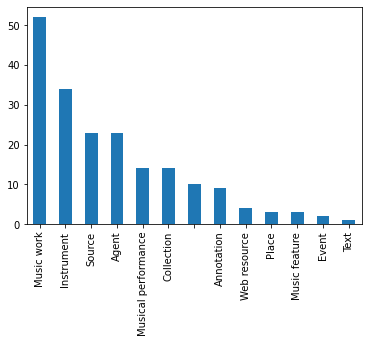

In [ ]:
# Main inputs
full_partial = df[(df["Coverage"] == 'full') | (df["Coverage"] == 'partial')]
full_partial["Input"].value_counts().plot(kind='bar');

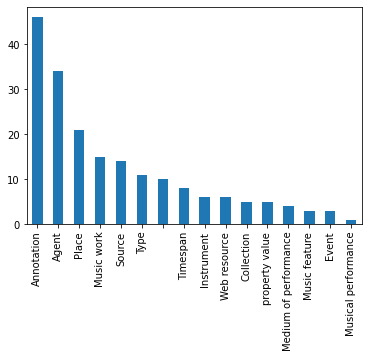

In [ ]:
# main outputs
full_partial["Output"].value_counts().plot(kind='bar');

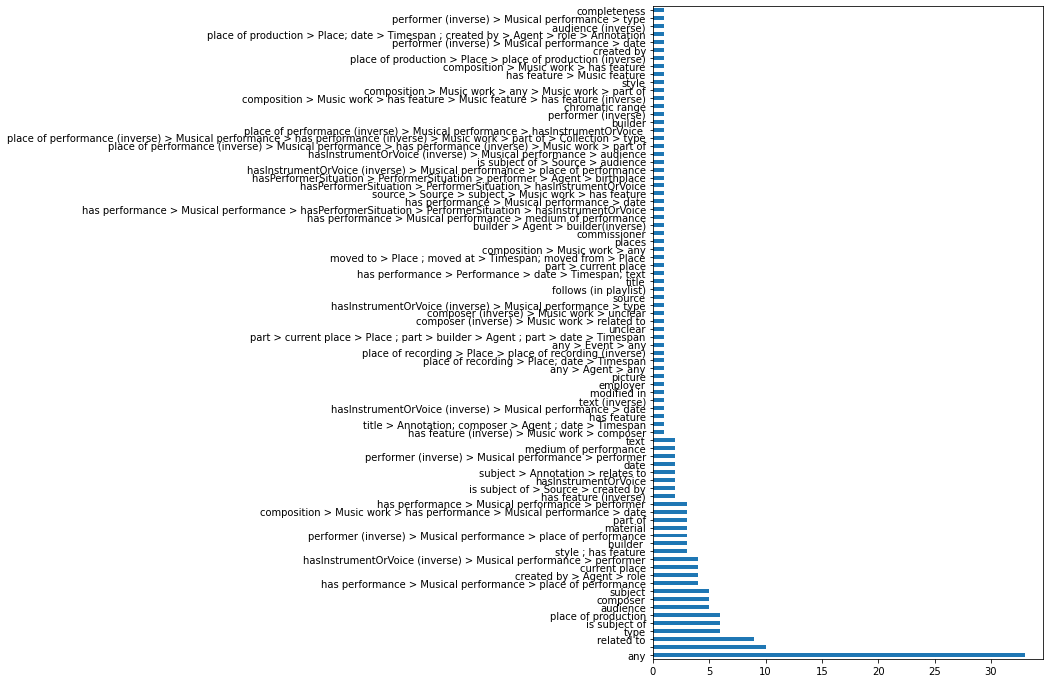

In [ ]:
# path
full_partial["Path"].value_counts().plot(kind='barh',figsize=(7, 12));

In [ ]:
works = full_partial.groupby(['Input', 'Path','Output']).size().reset_index(name='Size').drop_duplicates().reset_index(drop=True).sort_values(by=['Size'], ascending=False)
works

,Input,Path,Output,Size
0,,,,10
65,Music work,is subject of,Source,6
23,Collection,any,Annotation,6
93,Source,any,Annotation,6
56,Music work,composer,Agent,5
...,...,...,...,...
37,Instrument,date,Timespan,1
35,Instrument,chromatic range,Annotation,1
34,Instrument,builder > Agent > builder(inverse),Instrument,1
32,Instrument,builder,Agent,1


In [ ]:
# bigrams i/o
bgrams = full_partial.groupby(['Input','Output']).size().reset_index(name='Size').drop_duplicates().reset_index(drop=True)
bgrams = bgrams[bgrams["Input"] != '']
bgrams = bgrams.sort_values(by=['Size'], ascending=False)
bgrams.head(40)

,Input,Output,Size
52,Source,Annotation,15
21,Instrument,Annotation,11
1,Agent,Agent,9
38,Music work,Music work,9
31,Music work,Agent,9
39,Music work,Place,8
20,Instrument,Agent,8
13,Collection,Annotation,7
40,Music work,Source,7
24,Instrument,Place,6


In [ ]:
# bigrams
G = nx.DiGraph()
plt.figure()   
for  i, (x, y,s) in bgrams.iterrows():
    G.add_node(x)
    G.add_node(y)
    G.add_edges_from([(x,y)], weight=s)

viznet = NetworkViz(notebook=True, width="100%", height="400px")
viznet.toggle_hide_edges_on_drag(True)
viznet.barnes_hut()
viznet.repulsion(300)
viznet.heading = f"Bigrams input/output entities"

# reuse plotly color palette
palette = px.colors.diverging.Temps  # 7 colors
for edge in viznet.edges:
    # get value from main Network weight
    edge['value'] = G.edges[edge['from'], edge['to']]['weight']

viznet.from_nx(G)

viznet.show("concepts_network.html")

<Figure size 432x288 with 0 Axes>

In [ ]:
import plotly.graph_objs as go1

source = bgrams["Input"].to_list()
target = bgrams["Output"].to_list()
value  = bgrams["Size"].to_list()
label = list(set(source+target)) 
source = [i for s in source for i,x in enumerate(label) if x == s]
target = [i for s in target for i,x in enumerate(label) if x == s]
# data to dict, dict to sankey
link = dict(source = source, target = target, value = value)


node = dict(label = label, pad=20, thickness=10)
data = go1.Sankey(link = link, node=node)

# plot
#fig = go1.Figure(data)
#fig.show(renderer="colab")


In [ ]:
#!pip install pySankey
#from pySankey.sankey import sankey
#sankey_df = df[(df["Input"] != '') & (df["Output"] != '')]
#sankey(sankey_df["Input"], sankey_df["Output"], aspect=10,  fontsize=10)

In [ ]:
# count occurrence of paths
ipo = df[["Input","Path","Output"]]
ipoweb = df[["Input","Path","Output","Web \npage","Search \ninterface"]]

all_paths = []
# split by > props/entities
for  idx, (i, p, o, w , s) in ipoweb.iterrows(): 
  web = 'web' if (w == 'yes' or w == 'maybe') else 'none'
  search = 'search' if (s == 'yes' or s == 'maybe') else 'none'
  if o != 'property value':
    bits = [x.strip() for x in p.split(">")]
    if len(bits) < 2:
      multibits = [x.strip() for x in bits[0].split(';')]
      for b in multibits: 
        all_paths.append([i,b,o,'direct',web, search]) # direct path  
    else:
      all_paths.append([i,bits[0],bits[1],'indirect',web, search]) # at least one intermediate entity, two properties
      if len(bits) == 3:
        all_paths.append([bits[1],bits[2], o,'indirect',web, search])
      else:
        if len(bits) == 5:
          all_paths.append([bits[1],bits[2], bits[3],'indirect',web, search])
          all_paths.append([bits[3],bits[4], o,'indirect',web, search])
  else:
    multibits = [x.strip() for x in p.split(";")]
    for b in multibits:
      bits = [x.strip() for x in b.split(">")]
      if len(bits) == 2:
        all_paths.append([i,bits[0],bits[1],'direct',web, search])
      if len(bits) == 4:
        all_paths.append([i,bits[0],bits[1],'indirect',web, search])
        all_paths.append([bits[1],bits[2],bits[3],'indirect',web, search])
# count occurrences
from collections import Counter, defaultdict
all_paths_dict = dict(Counter(tuple(x) for x in all_paths))
all_paths_list = [ [k[0], k[1], k[2], k[3], k[4], k[5], v] for k,v in all_paths_dict.items()]

all_paths_dd = defaultdict(list)
for pattern in all_paths_list:
  all_paths_dd[pattern[0]].append( [pattern[1], pattern[2], pattern[3], pattern[4], pattern[5], pattern[6] ] ) 
all_paths_dd = dict(all_paths_dd)

all = []
for k,vlist in all_paths_dd.items():
  path = defaultdict(list)
  for prop_path in vlist:
    path[k].append( { "property":prop_path[0], "value": prop_path[1], prop_path[2]:prop_path[5], "web":prop_path[3], "search":prop_path[4] } )
  all.append(dict(path))

all = [x for x in all if '' not in x] # remove empty rows


In [ ]:
keys = [k for x in all for k,v in x.items()] # indexes

web_search_patterns = {}
# patterns
for x in all:
  for k,v in x.items():
    web_search_patterns[k] = defaultdict(list)
    web_patterns , search_patterns = set() , set()
    for d in v:
      path = d["property"]+' || '+d["value"]
      if d["web"] == "web":
        web_patterns.add(path)
      if d["search"] == "search":
        search_patterns.add(path)
    web_search_patterns[k]["web"] = { x.split(" || ")[0] : x.split(" || ")[1]  for x in list(web_patterns)}
    web_search_patterns[k]["search"] = { x.split(" || ")[0] : x.split(" || ")[1]  for x in list(search_patterns)}

#dict(web_search_patterns)

In [ ]:
all_paths = []
# split by > props/entities
for  idx, (i, p, o, w , s) in ipoweb.iterrows(): 
  if o != 'property value':
    bits = [x.strip() for x in p.split(">")]
    if len(bits) < 2: # direct paths
      multibits = [x.strip() for x in bits[0].split(';')]
      for b in multibits: 
        all_paths.append([i,b,o+' (1)']) # direct path  
    else:
      all_paths.append([i,bits[0],bits[1]+' (1)']) # at least one intermediate entity, two properties
      if len(bits) == 3:
        all_paths.append([bits[1]+' (1)',bits[2], o+' (2)'])
      else:
        if len(bits) == 5:
          all_paths.append([bits[1]+' (1)',bits[2], bits[3]+' (2)'])
          all_paths.append([bits[3]+' (2)',bits[4], o+' (3)'])
  else:
    multibits = [x.strip() for x in p.split(";")]
    for b in multibits:
      bits = [x.strip() for x in b.split(">")]
      if len(bits) == 2:
        all_paths.append([i,bits[0],bits[1]+' (1)'])
      if len(bits) == 4:
        all_paths.append([i,bits[0],bits[1]+' (1)'])
        all_paths.append([bits[1]+' (1)',bits[2],bits[3]+' (2)'])
# count occurrences
from collections import Counter, defaultdict
all_paths_dict = dict(Counter(tuple(x) for x in all_paths))
all_paths_list = [ [k[0], k[1], k[2], v] for k,v in all_paths_dict.items()]

all_paths_dd = defaultdict(list)
for pattern in all_paths_list:
  all_paths_dd[pattern[0]].append( [pattern[1], pattern[2], pattern[3] ] ) 
all_paths_dd = dict(all_paths_dd)

all = []
for k,vlist in all_paths_dd.items():
  for prop_path in vlist:
    all.append( { "subject":k, "property":prop_path[0], "value": prop_path[1], "count":prop_path[2] } )


all = [x for x in all if '' not in x.values()] # remove empty rows
all_df = pd.DataFrame(all)
#sankey(all_df["subject"], all_df["value"], aspect=20,  fontsize=10)

## Visualise data patterns

In [ ]:
# show distribution of patterns in a dataframe
sort_df = all_df.sort_values(by=['count'], ascending=False)
sort_df.head(40)

,subject,property,value,count
0,Music work,has performance,Musical performance (1),10
26,Musical performance (1),performer,Agent (2),9
57,Agent,performer (inverse),Musical performance (1),8
22,Musical performance (1),place of performance,Place (2),8
85,Collection,composition,Music work (1),7
3,Music work,is subject of,Source (1),7
44,Source,created by,Agent (1),6
48,Source,any,Annotation (1),6
86,Collection,any,Annotation (1),6
2,Music work,composer,Agent (1),6


In [ ]:
# show all data patterns in a sankey diagram
source = all_df["subject"].to_list()
target = all_df["value"].to_list()
value  = all_df["count"].to_list()
label = list(set(source+target)) 

source = [i for s in source for i,x in enumerate(label) if x == s]
target = [i for s in target for i,x in enumerate(label) if x == s]
# data to dict, dict to sankey
link = dict(source = source, target = target, value = value)


node = dict(label = label, pad=15, thickness=20,line = dict(color = "black", width = 0.5))
data = go1.Sankey(link = link, node=node)

# plot
fig = go1.Figure(data)
fig.show(renderer="colab")


In [ ]:
# show only patterns that occurr > 3 times
morethan3 = all_df[all_df['count'] >= 3]
source = morethan3["subject"].to_list()
target = morethan3["value"].to_list()
value  = morethan3["count"].to_list()
label = list(set(source+target)) 

source = [i for s in source for i,x in enumerate(label) if x == s]
target = [i for s in target for i,x in enumerate(label) if x == s]
# data to dict, dict to sankey
link = dict(source = source, target = target, value = value)


node = dict(label = label, pad=15, thickness=20,line = dict(color = "black", width = 0.5))
data = go1.Sankey(link = link, node=node)

# plot
fig = go1.Figure(data)
fig.show(renderer="colab")

In [ ]:
import plotly.graph_objects as go
!pip install chart-studio
import chart_studio.plotly as py

# music work 
mw_df = all_df[all_df["subject"].isin(['Music work','Musical Performance (1)'])]

source = mw_df["subject"].to_list()
target = mw_df["value"].to_list()
value  = mw_df["count"].to_list()
customdata = mw_df["property"].to_list()
label = list(set(source+target)) 
source = [i for s in source for i,x in enumerate(label) if x == s]
target = [i for s in target for i,x in enumerate(label) if x == s]


fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label,
      customdata = customdata,
      hovertemplate='total value %{value}<extra></extra>',
    ),
    link = dict(
      source = source, # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = target,
      value = value,
      customdata = customdata,
      hovertemplate='%{customdata}<extra></extra>',
  ))])

fig.update_layout(title_text="Music work", font_size=10)
fig.show()